In [94]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import psColor, bwLabel
import os

TRAIN_DIR = os.listdir(path='../data/treino')
DATA = [cv2.imread('../data/treino/' + image_path) for image_path in TRAIN_DIR]
TARGETS = [7, 5, 3, 4, 2, 4, 0, 3, 4, 4, 4, 1, 4, 3]

In [95]:
def showImages(imageArray, titles):
    for i, img in enumerate(imageArray):
        cv2.imshow(titles[i], img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

# esta função vai dar print dos valores BGR ao contrario porque o MatPlotLib é normal e usa RGB, 
# cuidado para ele não trocar os valores e a imagem ficar estranha
def pltImages(imageArray, titles, cmap = None):
    n_images = len(imageArray)
    for i, image in enumerate(imageArray):
        plt.subplot(n_images, 1, i + 1)
        plt.imshow(image, cmap=cmap)
        plt.title(titles[i])
        

In [96]:
#1. Leitura de imagens

image= DATA[8]

showImages([image], ["Imagem Original"])

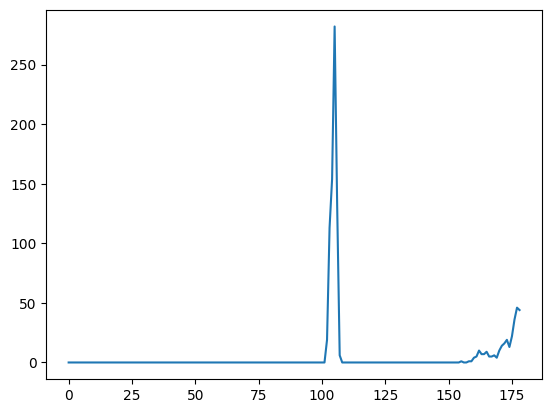

In [196]:
#2. Binarização 

def binarizacao (image, tolerance):
    """
    Função para realizar a binarização da imagem de modo a destacar os objetos presentes na mesma.

    Args:
        -image (np.array): Array da imagem em RGB que representa a imagem a ser binarização.
        -tolerance (int): Tolerância usada para calcular o range da componente Hue da cor de fundo da imagem. 

    Returns:
        -image_objects (np.array): Array da imagem RGB sem fundo.
        -bin_image (np.array): Array da imagem binarizada.
    
    """
    
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    #Obter a range de cores do fundo
    hist= cv2.calcHist(image_hsv, [0], None, [179], [0,179])
    plt.plot(hist)
    max_hue_idx= np.argmax(hist) #Obter o valor de hue que aparece mais na imagem
    low_hue= np.array([max_hue_idx - tolerance, 40, 0])
    high_hue= np.array([max_hue_idx + tolerance, 255, 255])
    
    #Tirar background da imagem através dos ranges de hue dados
    background_mask= cv2.inRange(image_hsv, low_hue, high_hue)
    inverted_mask= 255 - background_mask
    image_objects= cv2.bitwise_and(image, image, mask=inverted_mask)
    
    image_gs= cv2.cvtColor(image_objects, cv2.COLOR_BGR2GRAY)
    thresh, bin_image = cv2.threshold(image_gs, 0, 255, cv2.THRESH_OTSU)
    return image_objects, bin_image

image_objects, bin_image= binarizacao(image, 20)
showImages([image_objects, bin_image], ["Imagem sem background", "Imagem Binarizada"])


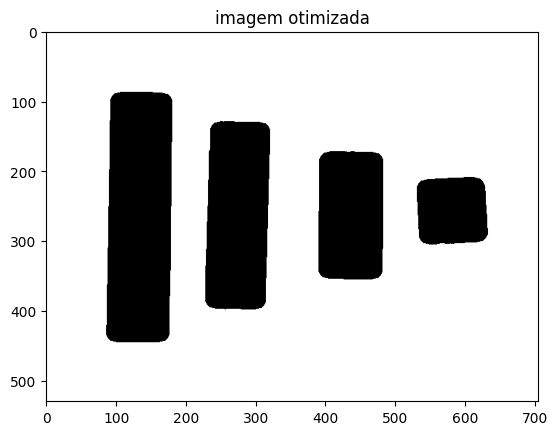

In [193]:
#3. melhoramento da imagem
def optimize_image(image):
    kernel_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    image_opt = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel_close)
    kernel_open = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
    image_opt = cv2.morphologyEx(image_opt, cv2.MORPH_OPEN, kernel_open, iterations=2)
    return image_opt

image_opt = optimize_image(bin_image)
showImages([image_opt], ["Imagem apos melhoramento"])
pltImages([image_opt], ["imagem otimizada"], 'Greys')

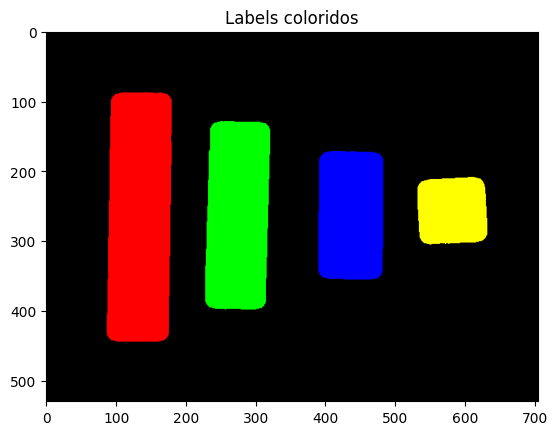

In [99]:
# Extração de componentes conexos

cc = cv2.connectedComponents(image_opt)

label_map = cc[1]

colored_image = np.zeros((image_opt.shape[0], image_opt.shape[1], 3), dtype=np.uint8)
colored_image[label_map == 1] = [255, 0, 0]
colored_image[label_map == 2] = [0, 255, 0]
colored_image[label_map == 3] = [0, 0, 255]
colored_image[label_map == 4] = [255, 255, 0]


showImages([colored_image], "contours")
pltImages([colored_image], ["Labels coloridos"])

In [100]:
#Extração de de propriedades

# Mati já te devo ter dito mas ya não consigo continuar se não tiver esta parte tua feita,
# usa a variavel cc lá de cima, a colored image é só para efeitos de display

# Na aula de hoje o prof tava a falar de reconhecimento de imagem com a cena dos centroides e tal, 
# e isso fez me pensar que ya, estas imagens são de treino porque nós vamos ter de literalmente treinar um modelo i think.
# That means we gonna have to think of how we can do that.
# Acho que variaveis de entrada seriam pelo menos a area e o perimetro, mas devem haver mais que conseguimos implementar.
# Vamos continuar a fazer isto tudo normalmente, mas deixa tudo o que é possiveis variaveis que identificam as peças (centroides de 
# area, perimetro, etc... para cada tipo diferente de peça) como inputs da tua função, o nosso modelo depois há de adaptar esses valores 
# com o treino que lhe dermos


# E és gay

In [146]:
#Extração de de propriedades

def extracao_propriedades (imagem_otimizada):
    num_labels, label_map_stats, stats, centroides= cv2.connectedComponentsWithStats(imagem_otimizada) 
    contours, hierarchy = cv2.findContours(imagem_otimizada, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) 
    
    propriedades= np.zeros((num_labels - 1, 10))
    
    for i in range(1,num_labels): #Skip no índice 0 porque corresponde ao background
        x= stats[i, cv2.CC_STAT_LEFT]
        y= stats[i, cv2.CC_STAT_TOP]
        width= stats[i, cv2.CC_STAT_WIDTH]
        height= stats[i, cv2.CC_STAT_HEIGHT]
        area= stats[i, cv2.CC_STAT_AREA]
        #A indexação está a ser feita desta forma porque o array de contornos tem a ordem inversa do array de connected components
        perimetro = cv2.arcLength(contours[len(contours) - i], True)  
        circularidade= 4* np.pi * area / perimetro **2
        rect = cv2.minAreaRect(contours[len(contours) - i])
        
        vetor_propriedades= np.array([x, y, width, height, area, centroides[i][0], centroides[i][1], circularidade, rect[1][0], rect[1][1]])
        propriedades[i-1]= vetor_propriedades
        
    return propriedades

propriedades_objectos= extracao_propriedades(image_opt)

In [149]:
#Classificação de objetos

def classificacao_objetos (propriedades, tolerancia_area= 1000):
    respostas= np.zeros((len(propriedades), 2))
    
    for i in range(len(propriedades)):
        vetor_prop= propriedades[i]
        minRectArea= vetor_prop[8] * vetor_prop[9]
        area= vetor_prop[4]
        if minRectArea - area < tolerancia_area:
            width= vetor_prop[2]
            height= vetor_prop[3]
            if np.abs(height - width) < 10:
                respostas[i]= np.array([2,2])
            else:
                cube_area= vetor_prop[8]**2
                if np.abs(cube_area * 2 - minRectArea) < tolerancia_area:
                    respostas[i]= np.array([4,2])
                elif np.abs(cube_area * 3 - minRectArea) < tolerancia_area:
                    respostas[i]= np.array([6,2])
                elif np.abs(cube_area * 4 - minRectArea) < tolerancia_area:
                    respostas[i]= np.array([8,2])
    return respostas

resultados= classificacao_objetos (propriedades_objectos)
print(resultados)

[[8. 2.]
 [6. 2.]
 [4. 2.]
 [2. 2.]]


[[0. 0.]
 [0. 0.]
 [4. 2.]]


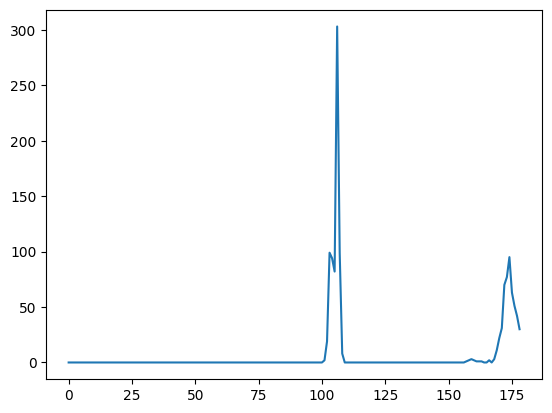

In [198]:
#Teste

imagem_teste= DATA[7]
showImages([imagem_teste], ["Imagem Original"])

imagem_teste_objects, bin_imagem_teste= binarizacao(imagem_teste, 10)
showImages([imagem_teste_objects, bin_imagem_teste], ["Imagem sem background", "Imagem Binarizada"])

imagem_teste_opt = optimize_image(bin_imagem_teste)
showImages([imagem_teste_opt], ["Imagem apos melhoramento"])

propriedades_objectos_teste= extracao_propriedades(imagem_teste_opt)
resultados_teste= classificacao_objetos (propriedades_objectos_teste)
print(resultados_teste)

[[4. 2.]
 [0. 0.]]


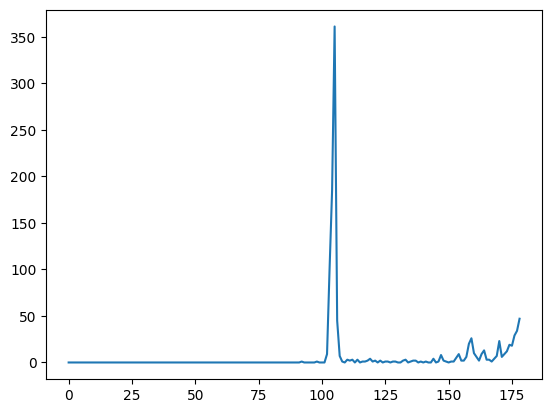

In [197]:
#Teste

imagem_teste2= DATA[4]
showImages([imagem_teste2], ["Imagem Original"])

imagem_teste2_objects, bin_imagem_teste2= binarizacao(imagem_teste2, 30)
showImages([imagem_teste2_objects, bin_imagem_teste2], ["Imagem sem background", "Imagem Binarizada"])

imagem_teste2_opt = optimize_image(bin_imagem_teste2)
showImages([imagem_teste2_opt], ["Imagem apos melhoramento"])

propriedades_objectos_teste2= extracao_propriedades(imagem_teste2_opt)
resultados_teste2= classificacao_objetos (propriedades_objectos_teste2)
print(resultados_teste2)